<a href="https://colab.research.google.com/github/Mateus-cpa/analise-tecnica-bolsa/blob/main/An%C3%A1lise_t%C3%A9cnica_de_a%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise na técnica bolsa de valores
- Análise técnica: https://www.infomoney.com.br/guias/analise-tecnica/




# Instalar Technical Analysis Library (TA-Lib)

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install TA-Lib

--2024-08-20 09:56:22--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-08-20 09:56:22--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-08-20 09:56:22--  http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Res

# Importar bibliotecas e API da Yahoo Finance

In [ ]:
#import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, timedelta
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

# Technical Analysis - TA-Lib
from talib import RSI # https://github.com/ta-lib/ta-lib-python

# API da Yahoo Finance
import yfinance as yf

# machine learning
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler # para normalizar os dados
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

## Outras bibliotecas


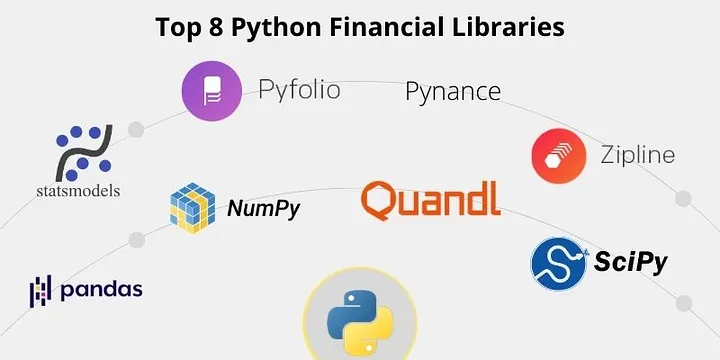

- [Pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/) - consegue os últimos dados de yahoo finance, google finance, bing finance
```
import pandas_datareader as pdr
pdr.get_data_fred('GS10')
```
- [Pynance](https://github.com/GriffinAustin/pynance/blob/develop/README.md) - analisa e visualiza dados de derivativos, gera funções para modelos de machine learning
```
import pynance as pn
```
- [Quandl](https://github.com/wilsonfreitas/awesome-quant) - dados de macroeconomia e financeiros de fundos, bancos.
```
pip install quandl
import quandl
```
-BRFinance
```
!pip install requests==2.28.2
import brfinance
from brfinance.backend import CVMAsyncBackend
from datetime import datetime, date
```

# Seleção de ativo e Análise gráfica

O Yahoo Finance responde a diversas informações através do comando:
```
#EXEMPLOS
petr = yf.Ticker('PETR4.SA')
petr_cot = petr.history(start = '2024-06-28', end = '2024-07-04', interval = '1m')
petr_cot = petr.history(period = 'max', interval = '1d')
```
ou ainda download completo de ticker ou  lista de tickers:
```
ticker = input('Digite o ticker do ativo: ')
ticker = ticker.upper()

start = '2021-01-01'
acao = yf.download(f'{ticker}.SA',
                   start = start,
                   end = date.today()-timedelta(days=1),
                   interval = '1d',
                   group_by='ticker').dropna();
```

In [ ]:
#entrada de escolha de ação
ticker = 'petr4'
#ticker = input('Digite o ticker do ativo: ')
ticker = ticker.upper()

start = '2017-01-01'


#importar dados da ação
acao = yf.download(f'{ticker}.SA', start = start, end = date.today(), interval = '1d', group_by='ticker').dropna();


#corrige último dado de 'Low' se estiver vazio
if pd.isna(acao.iloc[-1]['Close']):
  if (acao['Open'].iloc[-1] < acao['Close'].iloc[-1]):
    acao['Low'].iloc[-1] = acao['Open'].iloc[-1]
  else:
    acao['Low'].iloc[-1] = acao['Close'].iloc[-1]


#adiciona média móvel de 5, 72 e 200 períodos
acao['MM5'] = acao['Close'].rolling(window=5).mean()
acao['MM21'] = acao['Close'].rolling(window=21).mean()
acao['MM72'] = acao['Close'].rolling(window=72).mean()
acao['MM200'] = acao['Close'].rolling(window=200).mean()


#análise quando MM5 passa por MM72
acao['mudanca_tendencia'] = None  # Initialize the new column with empty strings

#calcula RSI
acao['rsi'] = RSI(acao['Close'], timeperiod=14)


for date in acao.index[1:-1]:  # Começar na segunda data
    previous_date = acao.index[acao.index.get_loc(date) - 1]  # pegar data anterior
    next_date = acao.index[acao.index.get_loc(date) + 1]  # pegar data posterior
    # Iterar no dataframe e marcar mudanças de tendência
    if (acao.loc[date, 'MM5'] > acao.loc[date, 'MM21']) and (acao.loc[previous_date, 'MM5'] <= acao.loc[previous_date, 'MM21']):
        acao.loc[previous_date, 'mudanca_tendencia'] = 'Alta'
    elif (acao.loc[date, 'MM5'] < acao.loc[date, 'MM21']) and (acao.loc[previous_date, 'MM5'] >= acao.loc[previous_date, 'MM21']):
        acao.loc[previous_date, 'mudanca_tendencia'] = 'Baixa'

    # Adicionar marcadores de topos e fundos em comparação a +/- 5 dias
for i in range(5, len(acao)-5):
    date = acao.index[i]
    previous_dates = acao.index[i-5:i]
    next_dates = acao.index[i+1:i+6]

    if all(acao.loc[date,'Close'] > acao.loc[previous_date,'Close'] for previous_date in previous_dates) and \
       all(acao.loc[date,'Close'] > acao.loc[next_date,'Close'] for next_date in next_dates):
        acao.loc[date,'marcador'] = 'topo'

    if all(acao.loc[date,'Close'] < acao.loc[previous_date,'Close'] for previous_date in previous_dates) and \
       all(acao.loc[date,'Close'] < acao.loc[next_date,'Close'] for next_date in next_dates):
        acao.loc[date,'marcador'] = 'fundo'

#Datas com marcadores
data_mudanca = acao[acao['mudanca_tendencia'].notnull()].index
data_topo = acao[acao['marcador'] == 'topo'].index
data_fundo = acao[acao['marcador'] == 'fundo'].index

display(acao)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,MM5,MM21,MM72,MM200,mudanca_tendencia,rsi,marcador
Date,,,,,,,,,,,,,
2017-01-02,14.640000,14.700000,14.600000,14.660000,4.839573,7525700,NaN,NaN,NaN,NaN,None,NaN,nan
2017-01-03,14.950000,15.650000,14.950000,15.500000,5.116875,39947800,NaN,NaN,NaN,NaN,None,NaN,nan
2017-01-04,15.450000,15.680000,15.310000,15.500000,5.116875,37071700,NaN,NaN,NaN,NaN,None,NaN,nan
2017-01-05,15.700000,15.910000,15.620000,15.750000,5.199406,47586300,NaN,NaN,NaN,NaN,None,NaN,nan
2017-01-06,15.780000,15.920000,15.500000,15.660000,5.169695,25592000,15.414000,NaN,NaN,NaN,None,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-13,37.529999,37.630001,36.970001,37.110001,37.110001,28557200,36.816000,37.249047,37.716250,37.93105,None,49.522301,nan
2024-08-14,37.189999,38.000000,37.160000,37.759998,37.759998,37955500,37.113999,37.218571,37.686667,37.93950,Alta,54.856719,nan
2024-08-15,38.049999,38.560001,38.000000,38.340000,38.340000,33409000,37.412000,37.206190,37.661389,37.95270,None,59.018485,nan


In [ ]:
#teste de aumentar range para +/- 5 de topos e fundos
lista_topos = []
lista_fundos = []
for i in range (1,6):
  try:
    data = acao.index[acao.index.get_loc(date) - i]  # pegar data anterior
    valor_topo = acao['Close'][data]
    lista_topos.append(valor_topo)
  except IndexError:
    break

for i in range (1,6):
  try:
    data = acao.index[acao.index.get_loc(date) + i]  # pegar data posterior
    valor_topo = acao['Close'][data]
    lista_topos.append(valor_topo)
  except IndexError:
    break

print(f'topos \n{lista_topos}')
max(lista_topos)


topos 
[36.5099983215332, 36.849998474121094, 36.27000045776367, 36.31999969482422, 35.70000076293945, 37.11000061035156, 37.7599983215332, 38.34000015258789, 38.5, 38.439998626708984]


38.5

In [ ]:
# criar figura com 2 subplots
fig = make_subplots(rows=2, cols=1, subplot_titles=('Ação', 'RSI'), row_heights=[0.8, 0.2])

#plotar gráfico principal
"""fig.add_trace(go.Candlestick(x=acao.index,
                              open=acao['Open'],
                              high=acao['High'],
                              low=acao['Low'],
                              close=acao['Close'],
                              increasing_line_color= 'blue',
                              decreasing_line_color= 'black'
                             ),
              row=1, col=1)"""

fig.add_trace(go.Scatter(x=acao.index,
                         y=acao['Close'],
                         name='Fechamento'))

fig.update_layout(yaxis_rangemode='normal')
#plt.bar(x=acao.index, height=acao['Volume'])

#linhas e marcadores
fig.add_trace(go.Scatter(x=acao.index,
                         y=acao['MM5'],
                         name='MM5'))
fig.add_trace(go.Scatter(x=acao.index,
                         y=acao['MM21'],
                         name='MM21')),
fig.add_trace(go.Scatter(x=acao.index,
                         y=acao['MM72'],
                         name='MM72'))
fig.add_trace(go.Scatter(x=acao.index,
                         y=acao['MM200'],
                         name='MM200'))
fig.add_trace(go.Scatter(x=data_mudanca,
                         y=acao.loc[data_mudanca, 'MM5'],
                         mode='markers',
                         name='Mudança de tendência',
                         marker=dict(color='orange')))
#adicionar topos e fundos
fig.add_trace(go.Scatter(x=data_topo,
                         y=acao['Close'][data_topo],
                         mode='markers',
                         name='Topos',
                         marker=dict(color='green')))
fig.add_trace(go.Scatter(x=data_fundo,
                         y=acao['Close'][data_fundo],
                         mode='markers',
                         name='Fundos',
                         marker=dict(color='red')))
#Segundo gráfico com RSI
fig.add_trace(go.Scatter(x=acao.index,
                         y=acao['rsi'],
                         name='RSI',
                         marker=dict(color='purple')),
              row=2, col=1)

#formatação

#layout
fig.update_layout(title=ticker)

fig.show()




In [ ]:
# criar figura com y-axis secundário
fig = make_subplots(rows=2, cols=1, subplot_titles=('Ação', 'RSI'), horizontal_spacing=0.5)

#plotar gráfico

# filtrar data inicial para gráfico detalhado
start = data_mudanca[-2] - timedelta(days=20)
acao_final = acao.loc[start:]
data_mudanca_final = acao_final[acao_final['mudanca_tendencia'].notnull()].index
data_topo_final = acao_final[acao_final['marcador'] == 'topo'].index
data_fundo_final = acao_final[acao_final['marcador'] == 'fundo'].index

#plotar
fig.add_trace(go.Candlestick(x=acao_final.index,
                open=acao_final['Open'],
                high=acao_final['High'],
                low=acao_final['Low'],
                close=acao_final['Close'],
                increasing_line_color= 'blue',
                decreasing_line_color= 'black')
              ,row=2,col=1)

#plt.bar(x=acao.index, height=acao['Volume'])

#linhas e marcadores
fig.add_trace(go.Scatter(x=acao_final.index, y=acao_final['Close'], name='Fechamento')
              ,row=2,col=1)
fig.add_trace(go.Scatter(x=acao_final.index, y=acao_final['MM5'], name='MM5')
              ,row=2,col=1)
fig.add_trace(go.Scatter(x=acao_final.index, y=acao_final['MM21'], name='MM21')
              ,row=2,col=1)
fig.add_trace(go.Scatter(x=acao_final.index, y=acao_final['MM72'], name='MM72')
              ,row=2,col=1)
fig.add_trace(go.Scatter(x=acao_final.index, y=acao_final['MM200'], name='MM200')
              ,row=2,col=1)
fig.add_trace(go.Scatter(x=data_mudanca_final,
                         y=acao_final.loc[data_mudanca_final, 'MM5'],
                         mode='markers',

                         name='Mudança de tendência'

                         #, marker=dict(color='red')
                         )
              ,row=2,col=1)
fig.update_yaxes(fixedrange=False, row=2, col=1)

#Gráfico RSI separado
fig.add_trace(go.Scatter(x=acao_final.index, y=acao_final['rsi'], name='RSI', marker=dict(color='purple')), row=1, col=1)

fig.update_layout(title= f"{ticker} em tendência de {acao_final.loc[data_mudanca[-1],'mudanca_tendencia']} desde {str(data_mudanca[-1])[0:10]}")

#não pular dados
fig.update_xaxes(dtick="D1")


fig.show()

## Modelo preditivo de ação

In [ ]:
#ajustar valor fechamento para o dia anterior
acao_prev = acao.copy()
acao_prev['Close'] = acao_prev['Close'].shift(-1) # passa o valor de fechamento para o dia anterior

#retirando dados vazios
acao_prev = acao_prev.drop(columns = ['mudanca_tendencia', 'marcador', 'Adj Close'])
acao_prev = acao_prev.dropna()

#verificando quantidade de linhas
qtd_linhas = len(acao_prev)

qtd_linhas_treino= round(.70 * qtd_linhas)
qtd_linhas_teste= qtd_linhas - qtd_linhas_treino
qtd_linhas_validacao = qtd_linhas -1

info = (
    f"linhas treino = 0:{qtd_linhas_treino} \n"
    f"linhas teste = {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1} \n"
    f"linhas validação = {qtd_linhas_validacao}"
)

print(info)

linhas treino = 0:1191 
linhas teste = 1191:1700 
linhas validação = 1700


In [ ]:
#separando as features e labels
features = acao_prev.drop(columns = ['Close']) # isola o dataframe da coluna de fechamento
labels = acao_prev['Close'] # seleciona apenas a coluna de fechamento para previsão

#testando quais features têm melhores resultados de previsão
features_list = ('Open','High','Low','Volume','MM5', 'MM21','MM72','MM200', 'rsi')

k_best_features = SelectKBest(k='all') # seleciona as melhores features (colunas)
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores) # transforma em dicionário os nomes das features e a pontuação de afinidade com a coluna de avaliação
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1]))) # ordena os maiores aos menores

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()

print ("Melhores features:")
print (k_best_features_final)

Melhores features:
{'Volume': 97.38468424101305, 'Low': 87.76845208897687, 'High': 72.30046614909345, 'MM21': 53.25464003557619, 'MM72': 18.166698501133936, 'MM200': 7.154108259285022, 'rsi': 3.865645393290997, 'MM5': 1.201208353792288}


In [ ]:
columns_features = []
for k,v in k_best_features_final.items():
  if v > 50:
    columns_features.append(k)

print(columns_features)

['Volume', 'Low', 'High', 'MM21']


In [ ]:
#separando as features escolhidas
features = acao_prev.loc[:,columns_features]
print (features)

              Volume        Low       High       MM21
Date                                                 
2017-10-16  44699700  16.000000  16.260000  15.706191
2017-10-17  25524800  16.070000  16.219999  15.758095
2017-10-18  25706200  16.129999  16.280001  15.806667
2017-10-19  24672800  15.900000  16.160000  15.820000
2017-10-20  32417500  16.170000  16.389999  15.846190
...              ...        ...        ...        ...
2024-08-12  39655100  36.799999  37.810001  37.315238
2024-08-13  28557200  36.970001  37.630001  37.249047
2024-08-14  37955500  37.160000  38.000000  37.218571
2024-08-15  33409000  38.000000  38.560001  37.206190
2024-08-16  35472700  38.029999  38.770000  37.204762

[1701 rows x 4 columns]


In [ ]:
#Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print(f'features: {features_scale.shape}')
features_scale

features: (1701, 4)


array([[0.091181  , 0.16240932, 0.1326398 , 0.06139281],
       [0.05206695, 0.16461681, 0.13133938, 0.06326569],
       [0.05243698, 0.16650894, 0.13329001, 0.0650183 ],
       ...,
       [0.0774238 , 0.82970667, 0.83940186, 0.83762607],
       [0.06814959, 0.85619674, 0.85760736, 0.83717933],
       [0.07235924, 0.85714278, 0.86443438, 0.83712778]])

In [ ]:
#Separa os dados de treino teste e validação
X_train = features_scale[:qtd_linhas_treino]
X_test = features_scale[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

1191 1191
510 510


In [ ]:
#treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
pred= lr.predict(X_test)
cd_lr =r2_score(y_test, pred)

print(f'Coeficiente de determinação regressão linear:{cd_lr * 100:.2f}')

Coeficiente de determinação regressão linear:97.71


In [ ]:
#rede neural
rn = MLPRegressor(max_iter=2000)

rn.fit(X_train, y_train)
pred= rn.predict(X_test)

cd_rn = rn.score(X_test, y_test)


print(f'Coeficiente de determinação rede neural:{cd_rn * 100:.2f}')

Coeficiente de determinação rede neural:97.74


In [ ]:
#rede neural com ajuste hyper parameters

rn_hp = MLPRegressor()

parameter_space = {
        'hidden_layer_sizes': [(i,) for i in list(range(1, 21))], # camada escondida, quantos neurônios. De 1 a 21, neste caso
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam', 'lbfgs'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
    }

search = GridSearchCV(rn_hp, parameter_space, n_jobs=-1, cv=5)


search.fit(X_train,y_train)
clf = search.best_estimator_
pred= search.predict(X_test)

cd_rnhp = search.score(X_test, y_test)

print(f'Coeficiente de determinação rede neural hiper parameters:{cd_rnhp * 100:.2f}')

Coeficiente de determinação rede neural hiper parameters:97.71


In [ ]:
#executando a previsão
previsao = features_scale[qtd_linhas_teste:qtd_linhas]
data_pregao_full = acao_prev.index

data_pregao = data_pregao_full[qtd_linhas_teste:qtd_linhas]

res_full = acao_prev['Close']
res = res_full[qtd_linhas_teste:qtd_linhas]

pred_lr = lr.predict(previsao) #utilizando regressão linear
pred_rn = rn.predict(previsao) #utilizando rede neural
try:
  pred_rnhp = clf.predict(previsao) #utilizando rede neural com ajuste hyper parameters
except:
  pred_rnhp = None
try:
  df=pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'previsao_regressao_linear':pred_lr, 'previsao_rede_neural': pred_rn, 'previsao_rede_neural_hiper_parameter': pred_rnhp})
except:
  df=pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'previsao_regressao_linear':pred_lr, 'previsao_rede_neural': pred_rn})

df.real = df.real.shift(+1)

df.set_index('data_pregao', inplace=True)

#gráfico
fig = make_subplots()

fig.update_layout(title=f'Preço das ações de {ticker}')

fig.add_trace(go.Scatter(x=df.index, y=df.real, name='Real', connectgaps=True))
fig.add_trace(go.Scatter(x=df.index, y=df.previsao_regressao_linear, name='Previsão regressão linear', mode='markers', connectgaps=True))
fig.add_trace(go.Scatter(x=df.index, y=df.previsao_rede_neural, name='Previsão rede neural', mode='markers', connectgaps=True))
fig.add_trace(go.Scatter(x=df.index, y=df.previsao_rede_neural_hiper_parameter, name='Previsão rede neural hiper parameter', mode='markers', connectgaps=True))

#posicionar legenda
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

print(f"Coeficientes:\n Regressão linear: {cd_lr*100:.2f} \n Rede neural:{cd_rn*100:.2f} \n Hiper parâmetros: {cd_rnhp*100:.2f}")

Coeficientes:
 Regressão linear: 97.71 
 Rede neural:97.74 
 Hiper parâmetros: 97.71


## Modelo para previsão de 10 dias com LSTM

In [ ]:
#normalizando novamente os dados para LSTM
scaler = StandardScaler()
df_para_lstm = pd.DataFrame(acao['Close'])

df_scaled = scaler.fit_transform(df_para_lstm)
print(df_scaled.shape)

#separando as linhas para o teste
train = df_scaled[:qtd_linhas_treino]
test = df_scaled[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste]
print(train.shape, test.shape)

(1901, 1)
(1191, 1) (510, 1)


In [ ]:
#converter uma array na matriz dataframe
def create_df(df, steps=1):
  dataX, dataY = [], []
  for i in range(len(df)-steps-1):
    a = df[i:(i+steps), 0]
    dataX.append(a)
    dataY.append(df[i + steps, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
#gerando dados de treino e teste
steps = 15
X_train, y_train = create_df(train, steps)
X_test, y_test = create_df(test, steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#gerando os dados que o modelo espera
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) #recriando o dados de treinamento. 1 para a quantidade de features recebidas
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#montando a rede
model = Sequential()
model.add(LSTM(35,
               return_sequences=True, #return_sequences input para o próximo teste
               input_shape=(steps, 1)))
model.add(LSTM(35,
               return_sequences=True)) #segundo teste, envia para o próximo teste
model.add(LSTM(35)) #teste final
model.add(Dropout(0.2)) # regulariza a informação para não causar overfitting
model.add(Dense(1)) # saída de uma 1 neurônio
model.compile(loss='mse',
              optimizer='adam') #um dos mais utilizados
model.summary()

(1175, 15) (1175,)
(494, 15) (494,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 15, 35)              │           5,180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 15, 35)              │           9,940 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 35)                  │           9,940 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 35)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              36 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,096 (98.03 KB)

 Trainable params: 25,096 (98.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinar modelo
validation = model.fit(X_train,
                       y_train,
                       epochs=100,
                       batch_size=15, #quantidade de informação por vez
                       validation_data=(X_test, y_test),
                       verbose=2) #ver como as informações estão sendo lotadas

Epoch 1/100
79/79 - 7s - 92ms/step - loss: 0.1361 - val_loss: 0.1396
Epoch 2/100
79/79 - 1s - 18ms/step - loss: 0.0620 - val_loss: 0.1245
Epoch 3/100
79/79 - 1s - 16ms/step - loss: 0.0462 - val_loss: 0.0737
Epoch 4/100
79/79 - 1s - 16ms/step - loss: 0.0398 - val_loss: 0.0625
Epoch 5/100
79/79 - 1s - 16ms/step - loss: 0.0353 - val_loss: 0.0509
Epoch 6/100
79/79 - 1s - 15ms/step - loss: 0.0315 - val_loss: 0.0498
Epoch 7/100
79/79 - 1s - 15ms/step - loss: 0.0316 - val_loss: 0.0650
Epoch 8/100
79/79 - 1s - 16ms/step - loss: 0.0305 - val_loss: 0.0486
Epoch 9/100
79/79 - 2s - 21ms/step - loss: 0.0302 - val_loss: 0.0468
Epoch 10/100
79/79 - 2s - 24ms/step - loss: 0.0268 - val_loss: 0.0438
Epoch 11/100
79/79 - 2s - 23ms/step - loss: 0.0254 - val_loss: 0.0577
Epoch 12/100
79/79 - 2s - 25ms/step - loss: 0.0238 - val_loss: 0.0447
Epoch 13/100
79/79 - 1s - 15ms/step - loss: 0.0228 - val_loss: 0.0442
Epoch 14/100
79/79 - 1s - 17ms/step - loss: 0.0217 - val_loss: 0.0409
Epoch 15/100
79/79 - 1s - 15m

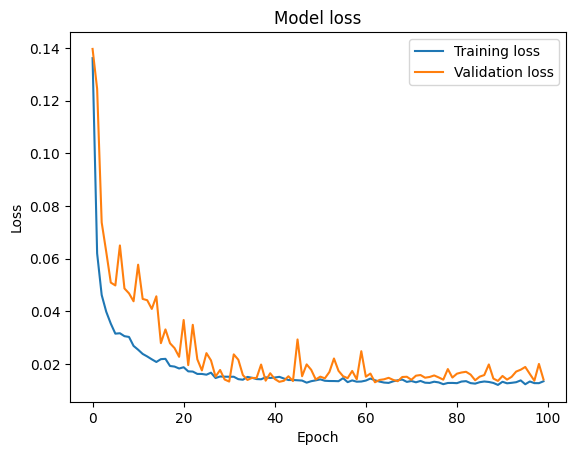

In [ ]:
plt.plot(validation.history['loss'], label='Training loss')
plt.plot(validation.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
print(f'x_test: {X_test.shape}')

x_test: (494, 15, 1)


In [ ]:
# visualizando a previsão
"""prev = model.predict(X_test)
prev = scaler.inverse_transform(prev) # dados desnormalizados
df_lstm = df_para_lstm.iloc[qtd_linhas_treino:qtd_linhas_treino,:]
display(df_lstm.head())
df_lstm['prev_lstm'] = prev
plt.plot(df_lstm, x= df_lstm.index, y = df_lstm.prec_lstm, label='Previsão')
plt.plot(df_lstm, x= df_lstm.index, y = df_lstm.Close, label='Real')
plt.legend()
plt.show()"""

"prev = model.predict(X_test)\nprev = scaler.inverse_transform(prev) # dados desnormalizados\ndf_lstm = df_para_lstm.iloc[qtd_linhas_treino:qtd_linhas_treino,:]\ndisplay(df_lstm.head())\ndf_lstm['prev_lstm'] = prev\nplt.plot(df_lstm, x= df_lstm.index, y = df_lstm.prec_lstm, label='Previsão')\nplt.plot(df_lstm, x= df_lstm.index, y = df_lstm.Close, label='Real')\nplt.legend()\nplt.show()"

### Testar modelo preditivo nos próximos 10 dias


In [ ]:
length_test = len(test) #tamanho predefinido de teste
print(length_test)

#pegar os últimos doas que são o tamano dos steps
days_input_steps = length_test - steps

print(f' Início teste: {df_para_lstm.iloc[qtd_linhas_treino + days_input_steps]}')


#transforma em array
input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1,-1) #ficar com 1 linha -1

#transformar em lista
list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist() #transforma em lista

print("dados de entrada:")
for i in range(0,len(list_output_steps)):
  print(f'{i} => {list_output_steps[i]}')

510
 Início teste: Close    34.950001
Name: 2023-10-09 00:00:00, dtype: float64
dados de entrada:
0 => 1.2940118985198277
1 => 1.330701726054394
2 => 1.3180012976167716
3 => 1.4816954095275612
4 => 1.5381418777644196
5 => 1.6778460522648486
6 => 1.7977946626898187
7 => 1.772393805814574
8 => 1.7032469091400932
9 => 1.3504578284432696
10 => 1.4252494796041193
11 => 1.452061255944248
12 => 1.3998486227288747
13 => 1.3631582568808918
14 => 1.312357081443819


In [ ]:
#loop para prever os próximos 10 dias
pred_output = [] # cria uma lista para recebre os 10dias futuros
i=0
n_futuro = 15 # qtde de 15 dias

while i < n_futuro:

  if (len(list_output_steps) > steps):

    input_steps = np.array(list_output_steps[1:])
    print(f'{i}º dia: valores de entrada => {input_steps}')
    input_steps = input_steps.reshape(1,-1)
    input_steps = input_steps.reshape((1, steps, 1))
    pred = model.predict(input_steps, verbose=0)
    print(f'{i}º dia: previsão => {pred}')
    list_output_steps.extend(pred[0].tolist())
    list_output_steps = list_output_steps[1:]
    pred_output.extend(pred[0].tolist())
    i+=1
  else:
    input_steps = input_steps.reshape((1, steps, 1))
    pred = model.predict(input_steps, verbose=0) #previsão
    print(f'{i}º dia: previsão => {pred[0]}')
    list_output_steps.extend(pred[0].tolist()) #deslocamento do tamanho da lista
    print(f'Tamanho da lista {len(list_output_steps)}')
    pred_output.extend(pred[0].tolist())
    i+=1

print(pred_output)

0º dia: previsão => [1.2458028]
Tamanho da lista 16
1º dia: valores de entrada => [1.33070173 1.3180013  1.48169541 1.53814188 1.67784605 1.79779466
 1.77239381 1.70324691 1.35045783 1.42524948 1.45206126 1.39984862
 1.36315826 1.31235708 1.24580276]
1º dia: previsão => [[1.1923946]]
2º dia: valores de entrada => [1.3180013  1.48169541 1.53814188 1.67784605 1.79779466 1.77239381
 1.70324691 1.35045783 1.42524948 1.45206126 1.39984862 1.36315826
 1.31235708 1.24580276 1.19239461]
2º dia: previsão => [[1.1550027]]
3º dia: valores de entrada => [1.48169541 1.53814188 1.67784605 1.79779466 1.77239381 1.70324691
 1.35045783 1.42524948 1.45206126 1.39984862 1.36315826 1.31235708
 1.24580276 1.19239461 1.15500271]
3º dia: previsão => [[1.1295236]]
4º dia: valores de entrada => [1.53814188 1.67784605 1.79779466 1.77239381 1.70324691 1.35045783
 1.42524948 1.45206126 1.39984862 1.36315826 1.31235708 1.24580276
 1.19239461 1.15500271 1.12952363]
4º dia: previsão => [[1.108213]]
5º dia: valores d

In [ ]:
# desnormaliza a saída
prev = scaler.inverse_transform(pd.DataFrame(pred_output))
prev = np.array(prev).reshape(1,-1)
prev = list(prev)
previsao_10_dias = prev[0].tolist()
for i in range(0,len(previsao_10_dias)):
  print(f'{[i]} => {previsao_10_dias[i]}')

[0] => 34.608372145208435
[1] => 34.22990134759297
[2] => 33.96492786157705
[3] => 33.78437324915452
[4] => 33.633357470668464
[5] => 33.480059142083846
[6] => 33.31863081270406
[7] => 33.157520114278036
[8] => 33.00625766494491
[9] => 32.8696307376168
[10] => 32.74637218753137
[11] => 32.63475531875914
[12] => 32.53245787733232
[13] => 32.43725391228508
[14] => 32.347706481456925


In [ ]:
#pegar as datas da previsão
datas_prev = acao_prev.index
predict_dates = pd.date_range(datas_prev[-1] + pd.DateOffset(1), periods=n_futuro,freq='b').tolist()

In [ ]:
# cria dataframe de previsão
forecast_dates = []
for i in predict_dates:
  forecast_dates.append(i.date())

df_forecast = pd.DataFrame({'data_pregao': np.array(forecast_dates), 'preco_previsao_fechamento': previsao_10_dias})
df_forecast['data_pregao'] = pd.to_datetime(df_forecast['data_pregao'])
df_forecast.set_index('data_pregao', inplace=True)

#concatenar datagframes df e df_forecast
df = pd.concat([acao_final,df_forecast])
df.tail(20)

,Open,High,Low,Close,Adj Close,Volume,MM5,MM21,MM72,MM200,mudanca_tendencia,rsi,marcador,preco_previsao_fechamento
2024-08-13,37.529999,37.630001,36.970001,37.110001,37.110001,28557200.0,36.816000,37.249047,37.716250,37.93105,None,49.522301,nan,NaN
2024-08-14,37.189999,38.000000,37.160000,37.759998,37.759998,37955500.0,37.113999,37.218571,37.686667,37.93950,Alta,54.856719,nan,NaN
2024-08-15,38.049999,38.560001,38.000000,38.340000,38.340000,33409000.0,37.412000,37.206190,37.661389,37.95270,None,59.018485,nan,NaN
2024-08-16,38.169998,38.770000,38.029999,38.500000,38.500000,35472700.0,37.810000,37.204762,37.631528,37.96800,None,60.110963,nan,NaN
2024-08-19,38.599998,38.790001,38.400002,38.439999,38.439999,28138200.0,38.030000,37.192857,37.592222,37.98480,None,59.470706,nan,NaN
2024-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.608372
2024-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.229901
2024-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.964928
2024-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.784373
2024-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.633357


In [ ]:
grafico_forecast = go.Figure()
grafico_forecast.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Real'))
grafico_forecast.add_trace(go.Scatter(x=df.index, y=df['preco_previsao_fechamento'], name='Previsão'))
grafico_forecast.show()

In [ ]:
#tentar não normalizar para evitar o gap

In [ ]:
# implementar este e os modelos anteriores para os próximos 10 dias

Fonte:
- https://www.infomoney.com.br/guias/analise-tecnica/
- Video previsão 10 dias: # https://www.youtube.com/watch?v=CvfAx3_nGME&list=PL1woXE9p74ASlH4i2QQytmASjle8Bt8An&index=7